<a href="https://colab.research.google.com/github/Praj825/crypto-dashboard/blob/main/TSA_for_cryptocurrency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoygukkqk/cvw9arlm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoygukkqk/4a5anyk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32342', 'data', 'file=/tmp/tmpoygukkqk/cvw9arlm.json', 'init=/tmp/tmpoygukkqk/4a5anyk7.json', 'output', 'file=/tmp/tmpoygukkqk/prophet_modelstt2mdyl/prophet_model-20250520055413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:54:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:54:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


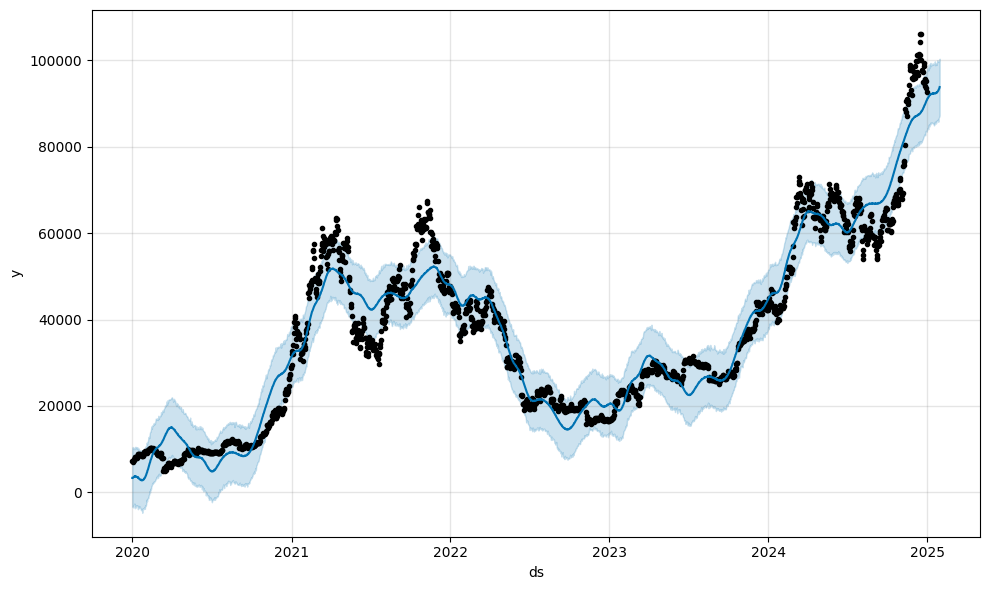

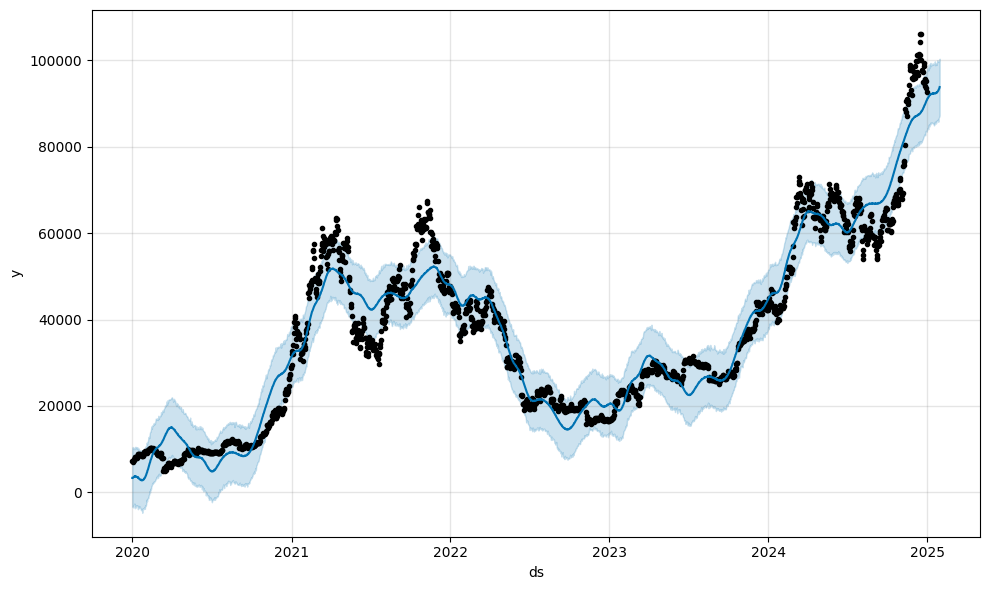

In [1]:
import yfinance as yf
import pandas as pd

# 1. Download BTC-USD data
df = yf.download('BTC-USD', start='2020-01-01', end='2024-12-31')

# 2. Add moving averages and return
df['MA7'] = df[('Close', 'BTC-USD')].rolling(window=7).mean()
df['MA30'] = df[('Close', 'BTC-USD')].rolling(window=30).mean()
df['Return'] = df[('Close', 'BTC-USD')].pct_change()

# 3. Flatten the MultiIndex columns
df.columns = ['_'.join(filter(None, col)).strip() for col in df.columns.values]

# 4. Reset index to get 'Date' column
df = df.reset_index()

# 5. Prepare for Prophet
prophet_df = df[['Date', 'Close_BTC-USD']].copy()
prophet_df.columns = ['ds', 'y']
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')
prophet_df.dropna(inplace=True)

# 6. Fit Prophet
from prophet import Prophet

model = Prophet()
model.fit(prophet_df)

# 7. Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# 8. Plot
model.plot(forecast)


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Join actuals with predictions
merged = prophet_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mae = mean_absolute_error(merged['y'], merged['yhat'])
r2 = r2_score(merged['y'], merged['yhat'])

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


RMSE: 5288.25, MAE: 4175.71, R²: 0.94


#API

In [3]:
!pip install fastapi uvicorn pyngrok nest_asyncio prophet yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00


In [4]:
import nest_asyncio
nest_asyncio.apply()


In [5]:
!ngrok authtoken 2x7XliUKrm0OLcL2a92qXIWHoWv_2dqkacPzJVZo8YQWvraCp


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# ✅ Step 1: Install necessary packages (if not already installed)
!pip install fastapi uvicorn pyngrok nest_asyncio prophet yfinance

# ✅ Step 2: Apply event loop patch for Colab
import nest_asyncio
nest_asyncio.apply()

# ✅ Step 3: Import libraries
from fastapi import FastAPI
from pyngrok import ngrok
import yfinance as yf
from prophet import Prophet
import pandas as pd
import uvicorn

# ✅ Step 4: Initialize FastAPI app
app = FastAPI()

# ✅ Step 5: Fixed train_model() function
@app.on_event("startup")
def train_model():
    global model, forecast

    # Download BTC data
    df = yf.download('BTC-USD', start='2020-01-01', end=None)
    df = df.reset_index()  # Reset index to get 'Date' as a column

    # Clean and format for Prophet
    df = df[['Date', 'Close']].copy()
    df.columns = ['ds', 'y']  # Prophet requires these column names
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df.dropna(inplace=True)

    # Fit the Prophet model
    model = Prophet()
    model.fit(df)

    # Forecast 30 days ahead
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

# ✅ Step 6: Define API endpoints
@app.get("/")
def root():
    return {"message": "Welcome to the Crypto Forecast API"}

@app.get("/price")
def get_price():
    df = yf.download('BTC-USD', period='1d', interval='1h')
    latest = df.tail(1)['Close'].values[0]
    return {"latest_price": float(latest)}

@app.get("/predict")
def get_forecast():
    return forecast[['ds', 'yhat']].tail(30).to_dict(orient='records')

@app.get("/actual_vs_predicted")
def actual_vs_predicted():
    try:
        # Download actual BTC-USD prices
        df = yf.download('BTC-USD', start='2020-01-01')
        df = df.reset_index()[['Date', 'Close']]
        df.columns = ['ds', 'y']
        df['ds'] = pd.to_datetime(df['ds'])
        df['y'] = pd.to_numeric(df['y'], errors='coerce')
        df.dropna(inplace=True)

        # Ensure forecast is ready
        if forecast is None:
            return {"error": "Forecast model not ready yet."}

        # Merge actual and forecast
        merged = pd.merge(df, forecast[['ds', 'yhat']], on='ds', how='inner')
        merged = merged.tail(30)  # return only recent 30 rows

        # Return as list of dicts
        return merged.to_dict(orient='records')

    except Exception as e:
        return {"error": str(e)}

# ✅ Step 7: Start ngrok tunnel and launch the server
public_url = ngrok.connect(8000)
print("🚀 FastAPI server is live at:", public_url)

uvicorn.run(app, host="0.0.0.0", port=8000)


<ipython-input-6-b89b45fa9693>:20: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
  @app.on_event("startup")
INFO:     Started server process [2864]
INFO:     Waiting for application startup.


🚀 FastAPI server is live at: NgrokTunnel: "https://e7a9-34-91-32-254.ngrok-free.app" -> "http://localhost:8000"


[*********************100%***********************]  1 of 1 completed
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoygukkqk/l7p5zmg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoygukkqk/vfl0vp94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48977', 'data', 'file=/tmp/tmpoygukkqk/l7p5zmg0.json', 'init=/tmp/tmpoygukkqk/vfl0vp94.json', 'output', 'file=/tmp/tmpoygukkqk/prophet_model20x3t7ut/prophet_model-20250520055511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:55:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:55:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:     Application startup complete.
INFO:     Uvicorn running on http

INFO:     34.127.33.101:0 - "GET /price HTTP/1.1" 200 OK
INFO:     34.127.33.101:0 - "GET /price HTTP/1.1" 200 OK



<ipython-input-6-b89b45fa9693>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"latest_price": float(latest)}


INFO:     34.127.33.101:0 - "GET /predict HTTP/1.1" 200 OK
INFO:     34.127.33.101:0 - "GET /predict HTTP/1.1" 200 OK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

INFO:     34.127.33.101:0 - "GET /actual_vs_predicted HTTP/1.1" 200 OK
INFO:     34.127.33.101:0 - "GET /actual_vs_predicted HTTP/1.1" 200 OK



[*********************100%***********************]  1 of 1 completed

INFO:     34.127.33.101:0 - "GET /price HTTP/1.1" 200 OK



<ipython-input-6-b89b45fa9693>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"latest_price": float(latest)}


INFO:     34.127.33.101:0 - "GET /predict HTTP/1.1" 200 OK


[*********************100%***********************]  1 of 1 completed

INFO:     34.127.33.101:0 - "GET /actual_vs_predicted HTTP/1.1" 200 OK



[*********************100%***********************]  1 of 1 completed

INFO:     34.127.33.101:0 - "GET /price HTTP/1.1" 200 OK



<ipython-input-6-b89b45fa9693>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"latest_price": float(latest)}


INFO:     34.127.33.101:0 - "GET /predict HTTP/1.1" 200 OK


[*********************100%***********************]  1 of 1 completed

INFO:     34.127.33.101:0 - "GET /actual_vs_predicted HTTP/1.1" 200 OK


In [ ]:
!pip install streamlit pyngrok


In [ ]:
%%writefile dashboard.py
import streamlit as st
import requests
import pandas as pd
import plotly.graph_objects as go

API_BASE_URL = "https://e7a9-34-91-32-254.ngrok-free.app"  # Replace with your ngrok URL

st.title("📈 Cryptocurrency Price Forecast Dashboard")

def get_latest_price():
    try:
        response = requests.get(f"{API_BASE_URL}/price")
        return response.json().get("latest_price", None)
    except:
        return None

def get_forecast():
    try:
        response = requests.get(f"{API_BASE_URL}/predict")
        data = response.json()
        return pd.DataFrame(data)
    except:
        return pd.DataFrame()

def get_actual_vs_predicted():
    try:
        response = requests.get(f"{API_BASE_URL}/actual_vs_predicted")
        data = response.json()
        return pd.DataFrame(data)
    except:
        return pd.DataFrame()

latest_price = get_latest_price()
if latest_price:
    st.metric("Latest BTC Price (USD)", f"${latest_price:,.2f}")
else:
    st.warning("Could not fetch latest price.")

forecast_df = get_forecast()
if not forecast_df.empty:
    forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['yhat'], mode='lines', name='Forecast'))
    fig.update_layout(title='30-Day BTC Price Forecast', xaxis_title='Date', yaxis_title='Price (USD)')
    st.plotly_chart(fig)
else:
    st.warning("Could not fetch forecast data.")

actual_pred_df = get_actual_vs_predicted()
if not actual_pred_df.empty:
    actual_pred_df['ds'] = pd.to_datetime(actual_pred_df['ds'])
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=actual_pred_df['ds'], y=actual_pred_df['y'], mode='lines+markers', name='Actual'))
    fig2.add_trace(go.Scatter(x=actual_pred_df['ds'], y=actual_pred_df['yhat'], mode='lines+markers', name='Predicted'))
    fig2.update_layout(title='Actual vs Predicted BTC Prices', xaxis_title='Date', yaxis_title='Price (USD)')
    st.plotly_chart(fig2)
else:
    st.warning("Could not fetch actual vs predicted data.")
